In [1]:
!pip install pandas sqlalchemy pyodbc

In [2]:
import urllib
from sqlalchemy import create_engine

# Replace with your actual server/instance
server = 'DESKTOP-6UNL5C8\SQLEXPRESS'
database = 'olist'

# Create the connection string
conn_str = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    "Trusted_Connection=yes;"
)

# URL encode it
conn_url = urllib.parse.quote_plus(conn_str)

# Create engine
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={conn_url}")


In [3]:
import pandas as pd

df = pd.read_csv("olist_customers_dataset.csv")  # Update path if needed
df.to_sql("customer", con=engine, if_exists="replace", index=False)

print("✅ Data loaded successfully!")


✅ Data loaded successfully!


In [4]:
import os

base_path = r"C:\Users\admin\Desktop\Aditya python"

tables = { "customer": "olist_customers_dataset.csv",}

for table, filename in tables.items():
    csv_path = os.path.join(base_path, filename)
    print(f"Loading {table} from {csv_path}")
    df = pd.read_csv(csv_path)
    df.to_sql(table, engine, if_exists="replace", index=False,schema='dbo')


Loading customer from C:\Users\admin\Desktop\Aditya python\olist_customers_dataset.csv


In [5]:
df_check = pd.read_sql("SELECT TOP 5 * FROM customers", engine)
df_check


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [13]:
import pandas as pd
import urllib
from sqlalchemy import create_engine

def get_sql_engine():
    server = 'DESKTOP-6UNL5C8\\SQLEXPRESS'
    database = 'olist'
    conn_str = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={server};"
        f"DATABASE={database};"
        "Trusted_Connection=yes;"
    )
    conn_url = urllib.parse.quote_plus(conn_str)
    return create_engine(f"mssql+pyodbc:///?odbc_connect={conn_url}")

def compute_customer_kpis():
    engine = get_sql_engine()

    # Load customer data
    customers = pd.read_sql("SELECT * FROM dbo.customer", engine)

    # KPI 1: Total number of unique customers
    total_customers = customers['customer_unique_id'].nunique()
    kpi_total_customers = pd.DataFrame({
        'kpi': ['total_unique_customers'],
        'value': [total_customers]
    })

    # KPI 2: Number of customers by state
    customers_by_state = customers.groupby('customer_state').size().reset_index(name='customer_count')

    # KPI 3: Most common customer city
    top_city = customers['customer_city'].value_counts().idxmax()
    top_city_count = customers['customer_city'].value_counts().max()
    kpi_top_city = pd.DataFrame({
        'kpi': ['most_common_city'],
        'value': [f"{top_city} ({top_city_count} customers)"]
    })

    # Save results to SQL Server
    kpi_total_customers.to_sql("kpi_total_customers", engine, if_exists="replace", index=False, schema="dbo")
    customers_by_state.to_sql("kpi_customers_by_state", engine, if_exists="replace", index=False, schema="dbo")
    kpi_top_city.to_sql("kpi_top_customer_city", engine, if_exists="replace", index=False, schema="dbo")

    print("✅ KPIs computed and stored in SQL Server.")

if __name__ == "__main__":
    compute_customer_kpis()


✅ KPIs computed and stored in SQL Server.


In [17]:
df_total = pd.read_sql("SELECT * FROM dbo.kpi_total_customers", engine)
print(df_total)

# Just display as text
print(f"✅ Total Unique Customers: {df_total['value'].values[0]}")


                      kpi  value
0  total_unique_customers  96096
✅ Total Unique Customers: 96096


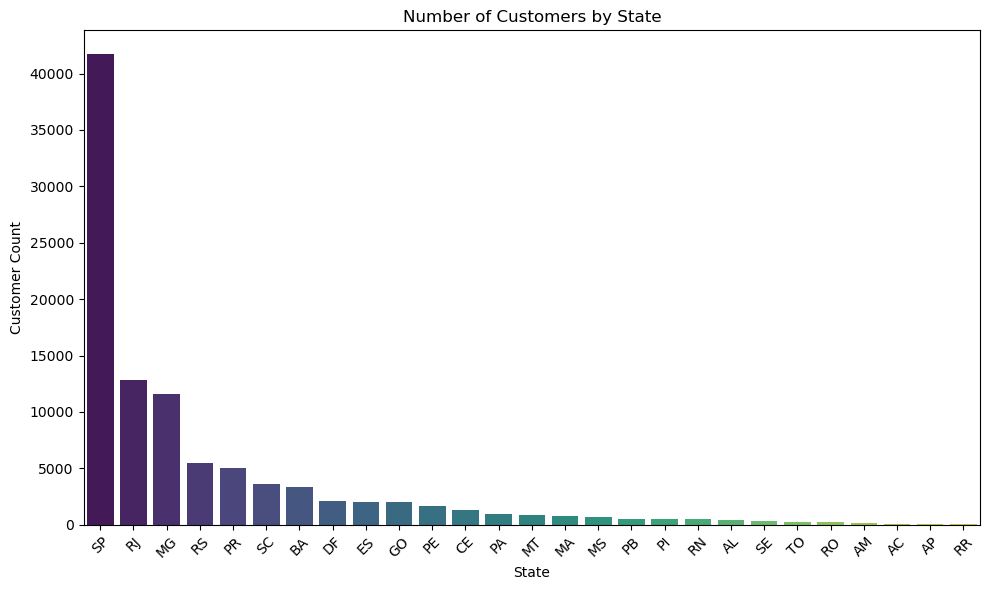

In [18]:
df_state = pd.read_sql("SELECT * FROM dbo.kpi_customers_by_state", engine)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_state.sort_values(by="customer_count", ascending=False), 
            x="customer_state", y="customer_count", palette="viridis")

plt.title("Number of Customers by State")
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
df_city = pd.read_sql("SELECT * FROM dbo.kpi_top_customer_city", engine)
print(df_city)

# Display result as text
print(f"🏙️ Most Common Customer City: {df_city['value'].values[0]}")


                kpi                        value
0  most_common_city  sao paulo (15540 customers)
🏙️ Most Common Customer City: sao paulo (15540 customers)
